<a href="https://colab.research.google.com/github/sedra-en/Smart-Alert/blob/main/End_Model_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_path = "/content/drive/MyDrive/archive.zip"
extract_path = "/content/archive"  # ممكن تغيّر الاسم

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import datetime
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model


In [ ]:
train_dir = "/content/archive/train/"
test_dir = "/content/archive/test/"



row, col = 48, 48
classes = 7

def count_exp(path, set_):
    dict_ = {}
    for expression in os.listdir(path):
        dir_ = path + expression
        dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index=[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       fear   sad  neutral  angry  disgust  surprise  happy
train  4097  4830     4965   3995      436      3171   7215
      fear   sad  neutral  angry  disgust  surprise  happy
test  1024  1247     1233    958      111       831   1774


<Axes: >

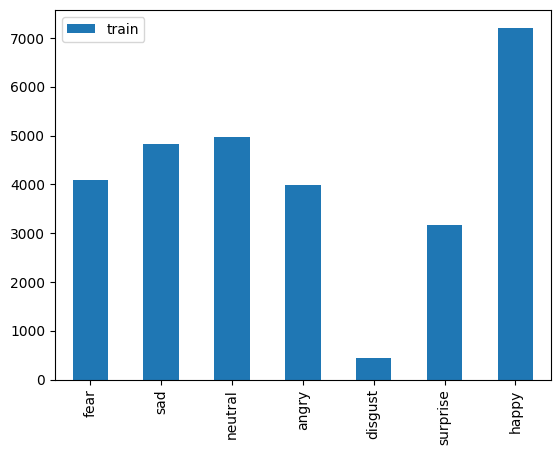

In [ ]:
train_count.transpose().plot(kind='bar')

<Axes: >

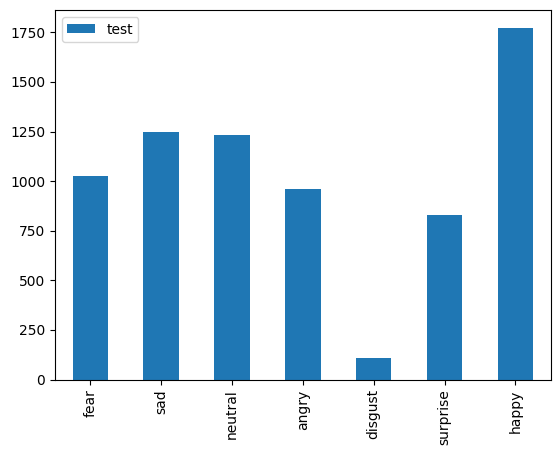

In [ ]:
test_count.transpose().plot(kind='bar')

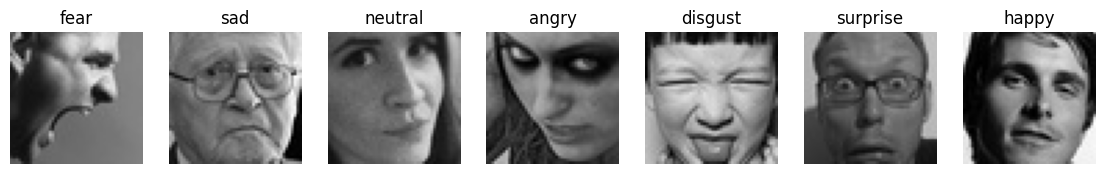

In [ ]:
plt.figure(figsize=(14,22))
i = 1
for expression in os.listdir(train_dir):
    img = load_img((train_dir + expression +'/'+ os.listdir(train_dir + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
plt.show()

In [ ]:
train_datagen = ImageDataGenerator( rescale=1./255,
    zoom_range=0.3,
    horizontal_flip=True,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=0.2,
    fill_mode='nearest')

training_set = train_datagen.flow_from_directory(train_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(test_dir,
                                                batch_size=64,
                                                target_size=(48,48),
                                                shuffle=True,
                                                color_mode='grayscale',
                                                class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
training_set.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
def get_model(input_size, classes=7):
    # Initialising the CNN
    model = tf.keras.models.Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu', input_shape=input_size))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(2, 2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.4))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.6))

    model.add(Dense(classes, activation='softmax'))

    # Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.0001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model




In [ ]:
# استدعاء النموذج:
fernet = get_model((row, col, 1), classes)
fernet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 48, 48, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 22, 22, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 22, 22, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 11, 11, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 30976)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    31,720,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │         7,175 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,116,743 (122.52 MB)

 Trainable params: 32,116,103 (122.51 MB)

 Non-trainable params: 640 (2.50 KB)

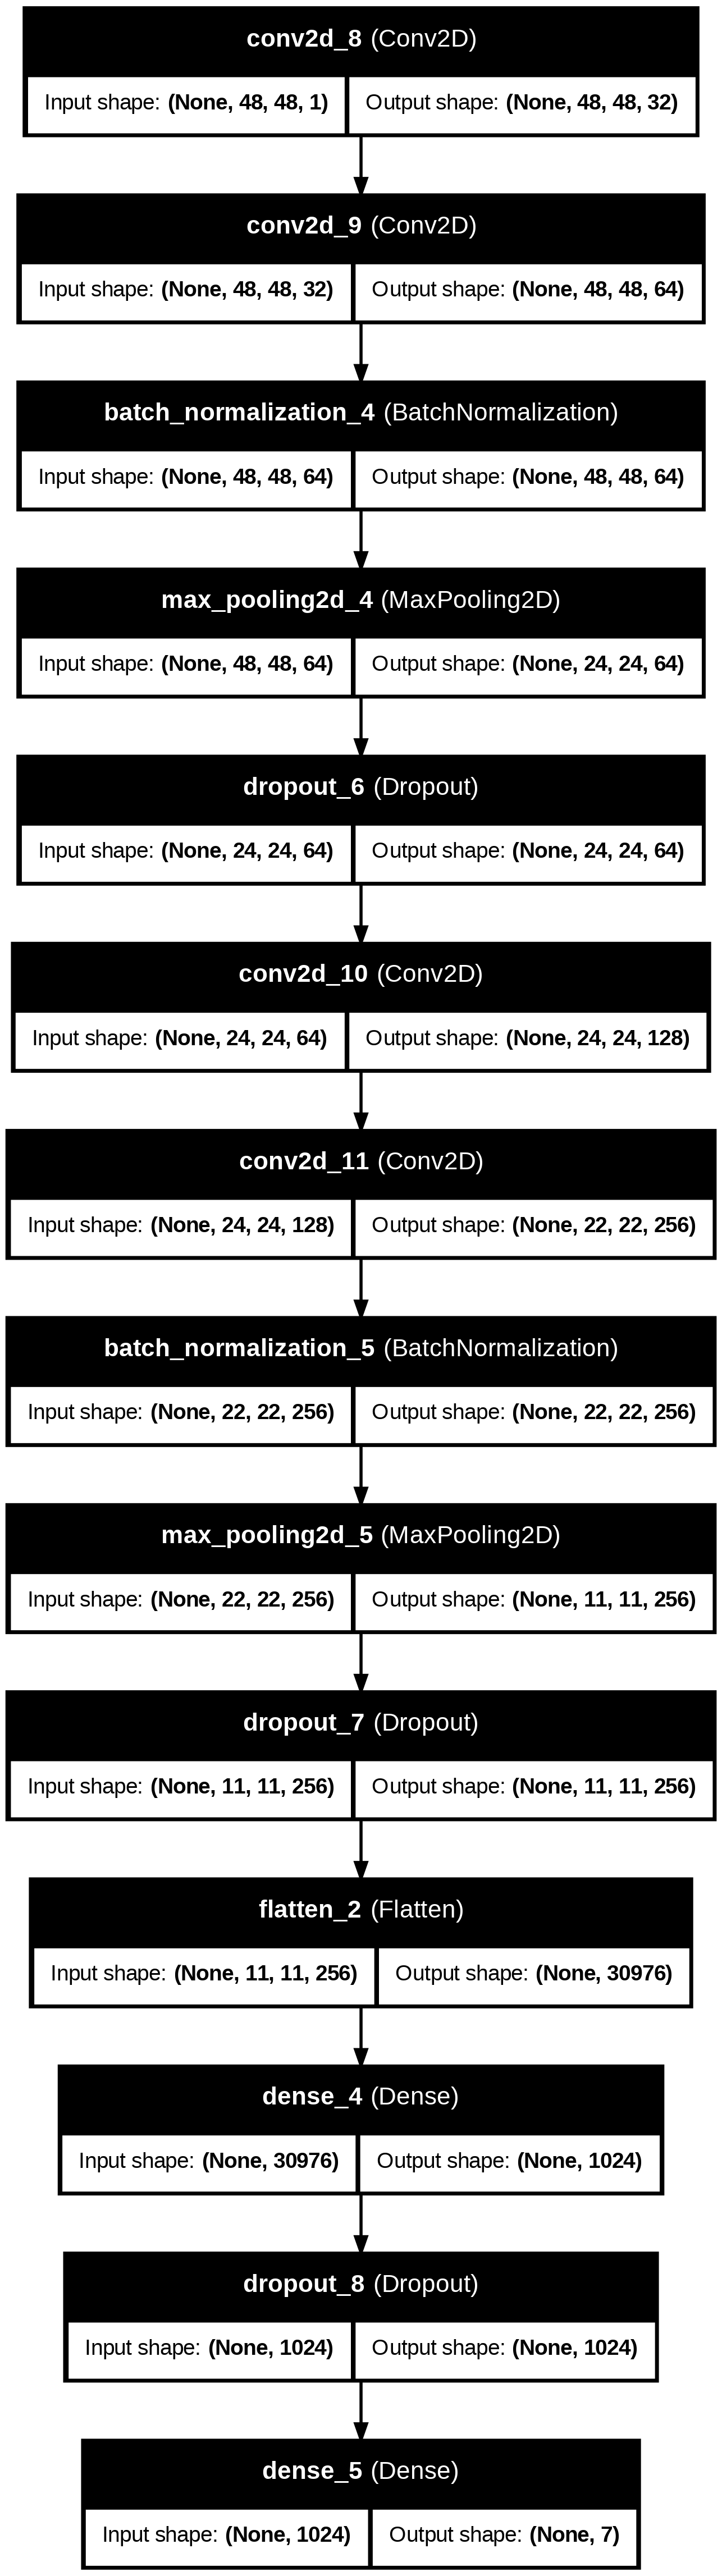

In [ ]:
plot_model(fernet, to_file='fernet.png', show_shapes=True, show_layer_names=True)

In [ ]:
chk_path = 'ferNet.h5'
log_dir = "checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=3,
                          verbose=1,
                          restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=6,
                              verbose=1,
                              min_delta=0.0001)


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger('training.log')

callbacks = [checkpoint, reduce_lr, csv_logger]

In [ ]:
steps_per_epoch = training_set.n // training_set.batch_size
validation_steps = test_set.n // test_set.batch_size

hist = fernet.fit(x=training_set,
                 validation_data=test_set,
                 epochs=60,
                 callbacks=callbacks,
                 steps_per_epoch=steps_per_epoch,
                 validation_steps=validation_steps)

Epoch 1/60


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.2523 - loss: 4.9613
Epoch 1: val_loss improved from inf to 4.46080, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 43s 75ms/step - accuracy: 0.2524 - loss: 4.9597 - val_accuracy: 0.2076 - val_loss: 4.4608 - learning_rate: 1.0000e-04
Epoch 2/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 18s 42ms/step - accuracy: 0.3438 - loss: 3.6885

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_loss improved from 4.46080 to 4.43257, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.3438 - loss: 3.6885 - val_accuracy: 0.2122 - val_loss: 4.4326 - learning_rate: 1.0000e-04
Epoch 3/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3279 - loss: 3.6280
Epoch 3: val_loss improved from 4.43257 to 3.10394, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 62s 58ms/step - accuracy: 0.3279 - loss: 3.6277 - val_accuracy: 0.4086 - val_loss: 3.1039 - learning_rate: 1.0000e-04
Epoch 4/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 17s 38ms/step - accuracy: 0.4062 - loss: 3.3100
Epoch 4: val_loss improved from 3.10394 to 3.10148, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4062 - loss: 3.3100 - val_accuracy: 0.4086 - val_loss: 3.1015 - learning_rate: 1.0000e-04
Epoch 5/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3729 - loss: 3.0685
Epoch 5: val_loss improved from 3.10148 to 2.62784, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 39s 61ms/step - accuracy: 0.3730 - loss: 3.0680 - val_accuracy: 0.4369 - val_loss: 2.6278 - learning_rate: 1.0000e-04
Epoch 6/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4062 - loss: 2.7696
Epoch 6: val_loss improved from 2.62784 to 2.62536, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4062 - loss: 2.7696 - val_accuracy: 0.4364 - val_loss: 2.6254 - learning_rate: 1.0000e-04
Epoch 7/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4030 - loss: 2.6035
Epoch 7: val_loss improved from 2.62536 to 2.24692, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.4031 - loss: 2.6033 - val_accuracy: 0.4602 - val_loss: 2.2469 - learning_rate: 1.0000e-04
Epoch 8/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.4062 - loss: 2.2589
Epoch 8: val_loss improved from 2.24692 to 2.24557, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4062 - loss: 2.2589 - val_accuracy: 0.4597 - val_loss: 2.2456 - learning_rate: 1.0000e-04
Epoch 9/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4321 - loss: 2.2797
Epoch 9: val_loss improved from 2.24557 to 1.97292, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 40s 90ms/step - accuracy: 0.4321 - loss: 2.2794 - val_accuracy: 0.4859 - val_loss: 1.9729 - learning_rate: 1.0000e-04
Epoch 10/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.4375 - loss: 1.8756
Epoch 10: val_loss did not improve from 1.97292
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4375 - loss: 1.8756 - val_accuracy: 0.4775 - val_loss: 1.9863 - learning_rate: 1.0000e-04
Epoch 11/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4490 - loss: 2.0290
Epoch 11: val_loss improved from 1.97292 to 1.81639, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.4490 - loss: 2.0288 - val_accuracy: 0.4813 - val_loss: 1.8164 - learning_rate: 1.0000e-04
Epoch 12/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.4688 - loss: 1.9560
Epoch 12: val_loss improved from 1.81639 to 1.81243, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4688 - loss: 1.9560 - val_accuracy: 0.4824 - val_loss: 1.8124 - learning_rate: 1.0000e-04
Epoch 13/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4763 - loss: 1.8286
Epoch 13: val_loss improved from 1.81243 to 1.65241, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 92ms/step - accuracy: 0.4763 - loss: 1.8284 - val_accuracy: 0.5049 - val_loss: 1.6524 - learning_rate: 1.0000e-04
Epoch 14/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5000 - loss: 1.6556
Epoch 14: val_loss improved from 1.65241 to 1.64620, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.5000 - loss: 1.6556 - val_accuracy: 0.5078 - val_loss: 1.6462 - learning_rate: 1.0000e-04
Epoch 15/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4931 - loss: 1.6761
Epoch 15: val_loss improved from 1.64620 to 1.49285, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - accuracy: 0.4931 - loss: 1.6760 - val_accuracy: 0.5513 - val_loss: 1.4928 - learning_rate: 1.0000e-04
Epoch 16/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 18s 40ms/step - accuracy: 0.5625 - loss: 1.4407
Epoch 16: val_loss did not improve from 1.49285
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5625 - loss: 1.4407 - val_accuracy: 0.5477 - val_loss: 1.4973 - learning_rate: 1.0000e-04
Epoch 17/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5170 - loss: 1.5531
Epoch 17: val_loss improved from 1.49285 to 1.43423, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.5170 - loss: 1.5531 - val_accuracy: 0.5441 - val_loss: 1.4342 - learning_rate: 1.0000e-04
Epoch 18/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.4688 - loss: 1.5339
Epoch 18: val_loss improved from 1.43423 to 1.42152, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4688 - loss: 1.5339 - val_accuracy: 0.5462 - val_loss: 1.4215 - learning_rate: 1.0000e-04
Epoch 19/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5317 - loss: 1.4621
Epoch 19: val_loss improved from 1.42152 to 1.35181, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 27s 61ms/step - accuracy: 0.5317 - loss: 1.4620 - val_accuracy: 0.5603 - val_loss: 1.3518 - learning_rate: 1.0000e-04
Epoch 20/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 17s 40ms/step - accuracy: 0.6250 - loss: 1.4432
Epoch 20: val_loss improved from 1.35181 to 1.34816, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6250 - loss: 1.4432 - val_accuracy: 0.5642 - val_loss: 1.3482 - learning_rate: 1.0000e-04
Epoch 21/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5451 - loss: 1.3923
Epoch 21: val_loss improved from 1.34816 to 1.28739, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 91ms/step - accuracy: 0.5451 - loss: 1.3923 - val_accuracy: 0.5788 - val_loss: 1.2874 - learning_rate: 1.0000e-04
Epoch 22/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.5312 - loss: 1.3873
Epoch 22: val_loss did not improve from 1.28739
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.5312 - loss: 1.3873 - val_accuracy: 0.5769 - val_loss: 1.2894 - learning_rate: 1.0000e-04
Epoch 23/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.5608 - loss: 1.3284
Epoch 23: val_loss improved from 1.28739 to 1.24779, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 64s 58ms/step - accuracy: 0.5608 - loss: 1.3284 - val_accuracy: 0.5871 - val_loss: 1.2478 - learning_rate: 1.0000e-04
Epoch 24/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 18s 41ms/step - accuracy: 0.4844 - loss: 1.4577
Epoch 24: val_loss did not improve from 1.24779
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.4844 - loss: 1.4577 - val_accuracy: 0.5854 - val_loss: 1.2513 - learning_rate: 1.0000e-04
Epoch 25/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.5788 - loss: 1.2688
Epoch 25: val_loss improved from 1.24779 to 1.21627, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 45s 100ms/step - accuracy: 0.5788 - loss: 1.2688 - val_accuracy: 0.5880 - val_loss: 1.2163 - learning_rate: 1.0000e-04
Epoch 26/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6562 - loss: 1.1972
Epoch 26: val_loss did not improve from 1.21627
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6562 - loss: 1.1972 - val_accuracy: 0.5850 - val_loss: 1.2240 - learning_rate: 1.0000e-04
Epoch 27/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5942 - loss: 1.2206
Epoch 27: val_loss improved from 1.21627 to 1.20508, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 63s 62ms/step - accuracy: 0.5942 - loss: 1.2206 - val_accuracy: 0.5947 - val_loss: 1.2051 - learning_rate: 1.0000e-04
Epoch 28/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.6094 - loss: 1.3089
Epoch 28: val_loss improved from 1.20508 to 1.20173, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.6094 - loss: 1.3089 - val_accuracy: 0.5932 - val_loss: 1.2017 - learning_rate: 1.0000e-04
Epoch 29/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6051 - loss: 1.1796
Epoch 29: val_loss did not improve from 1.20173
448/448 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.6051 - loss: 1.1796 - val_accuracy: 0.5882 - val_loss: 1.2043 - learning_rate: 1.0000e-04
Epoch 30/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 13s 31ms/step - accuracy: 0.6250 - loss: 1.1392
Epoch 30: val_loss did not improve from 1.20173
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6250 - loss: 1.1392 - val_accuracy: 0.5882 - val_loss: 1.2064 - learning_rate: 1.0000e-04
Epoch 31/60
447/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6111 - loss: 1.1551
Epoch 31: val_loss improved from 1.20173 to 1.19161, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 38s 59ms/step - accuracy: 0.6111 - loss: 1.1551 - val_accuracy: 0.5999 - val_loss: 1.1916 - learning_rate: 1.0000e-04
Epoch 32/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 19s 43ms/step - accuracy: 0.5938 - loss: 1.0958
Epoch 32: val_loss improved from 1.19161 to 1.18932, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5938 - loss: 1.0958 - val_accuracy: 0.6002 - val_loss: 1.1893 - learning_rate: 1.0000e-04
Epoch 33/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6158 - loss: 1.1307
Epoch 33: val_loss improved from 1.18932 to 1.16331, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 90ms/step - accuracy: 0.6158 - loss: 1.1307 - val_accuracy: 0.6044 - val_loss: 1.1633 - learning_rate: 1.0000e-04
Epoch 34/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.6406 - loss: 1.1169
Epoch 34: val_loss did not improve from 1.16331
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6406 - loss: 1.1169 - val_accuracy: 0.6035 - val_loss: 1.1638 - learning_rate: 1.0000e-04
Epoch 35/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6216 - loss: 1.1004
Epoch 35: val_loss improved from 1.16331 to 1.15121, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 42s 95ms/step - accuracy: 0.6216 - loss: 1.1004 - val_accuracy: 0.6101 - val_loss: 1.1512 - learning_rate: 1.0000e-04
Epoch 36/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.5625 - loss: 1.1392
Epoch 36: val_loss improved from 1.15121 to 1.14911, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5625 - loss: 1.1392 - val_accuracy: 0.6112 - val_loss: 1.1491 - learning_rate: 1.0000e-04
Epoch 37/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6423 - loss: 1.0606
Epoch 37: val_loss improved from 1.14911 to 1.14849, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 27s 60ms/step - accuracy: 0.6423 - loss: 1.0607 - val_accuracy: 0.6064 - val_loss: 1.1485 - learning_rate: 1.0000e-04
Epoch 38/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 20s 47ms/step - accuracy: 0.6406 - loss: 1.1987
Epoch 38: val_loss did not improve from 1.14849
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6406 - loss: 1.1987 - val_accuracy: 0.6048 - val_loss: 1.1515 - learning_rate: 1.0000e-04
Epoch 39/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.6433 - loss: 1.0524
Epoch 39: val_loss did not improve from 1.14849
448/448 ━━━━━━━━━━━━━━━━━━━━ 41s 67ms/step - accuracy: 0.6433 - loss: 1.0523 - val_accuracy: 0.6031 - val_loss: 1.1674 - learning_rate: 1.0000e-04
Epoch 40/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.6250 - loss: 0.9304
Epoch 40: val_loss did not improve from 1.14849
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6250 - loss: 0.9304 - val_accuracy: 0.6038 - val_loss: 1.1682 - learning_rate: 1.0000e-04
Epoch 

448/448 ━━━━━━━━━━━━━━━━━━━━ 45s 80ms/step - accuracy: 0.6542 - loss: 1.0168 - val_accuracy: 0.6191 - val_loss: 1.1058 - learning_rate: 1.0000e-04
Epoch 42/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - accuracy: 0.5469 - loss: 1.1691
Epoch 42: val_loss improved from 1.10580 to 1.10392, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - accuracy: 0.5469 - loss: 1.1691 - val_accuracy: 0.6200 - val_loss: 1.1039 - learning_rate: 1.0000e-04
Epoch 43/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6638 - loss: 0.9969
Epoch 43: val_loss improved from 1.10392 to 1.10232, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 82s 98ms/step - accuracy: 0.6638 - loss: 0.9969 - val_accuracy: 0.6244 - val_loss: 1.1023 - learning_rate: 1.0000e-04
Epoch 44/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.5469 - loss: 1.1249
Epoch 44: val_loss did not improve from 1.10232
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5469 - loss: 1.1249 - val_accuracy: 0.6232 - val_loss: 1.1052 - learning_rate: 1.0000e-04
Epoch 45/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6790 - loss: 0.9549
Epoch 45: val_loss did not improve from 1.10232
448/448 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.6790 - loss: 0.9549 - val_accuracy: 0.6144 - val_loss: 1.1578 - learning_rate: 1.0000e-04
Epoch 46/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.6719 - loss: 1.0525
Epoch 46: val_loss did not improve from 1.10232
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6719 - loss: 1.0525 - val_accuracy: 0.6193 - val_loss: 1.1472 - learning_rate: 1.0000e-04
Epoch 

448/448 ━━━━━━━━━━━━━━━━━━━━ 42s 94ms/step - accuracy: 0.6927 - loss: 0.9256 - val_accuracy: 0.6412 - val_loss: 1.0844 - learning_rate: 1.0000e-04
Epoch 50/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 15s 34ms/step - accuracy: 0.6562 - loss: 0.9581
Epoch 50: val_loss did not improve from 1.08437
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6562 - loss: 0.9581 - val_accuracy: 0.6398 - val_loss: 1.0851 - learning_rate: 1.0000e-04
Epoch 51/60
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.6973 - loss: 0.9108
Epoch 51: val_loss did not improve from 1.08437
448/448 ━━━━━━━━━━━━━━━━━━━━ 82s 100ms/step - accuracy: 0.6973 - loss: 0.9108 - val_accuracy: 0.6349 - val_loss: 1.1193 - learning_rate: 1.0000e-04
Epoch 52/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.6406 - loss: 0.9000
Epoch 52: val_loss did not improve from 1.08437
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6406 - loss: 0.9000 - val_accuracy: 0.6331 - val_loss: 1.1187 - learning_rate: 1.0000e-04
Epoch

448/448 ━━━━━━━━━━━━━━━━━━━━ 45s 79ms/step - accuracy: 0.7526 - loss: 0.7634 - val_accuracy: 0.6483 - val_loss: 1.0826 - learning_rate: 2.0000e-05
Epoch 60/60
  1/448 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - accuracy: 0.7969 - loss: 0.8151
Epoch 60: val_loss improved from 1.08259 to 1.08204, saving model to ferNet.h5


448/448 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7969 - loss: 0.8151 - val_accuracy: 0.6482 - val_loss: 1.0820 - learning_rate: 2.0000e-05


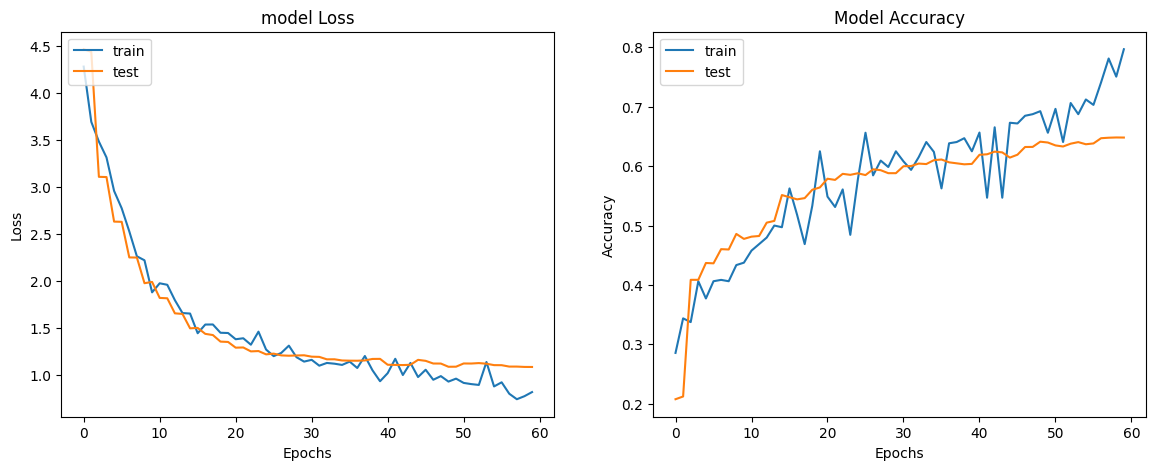

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1,2,1)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
train_loss, train_accu = fernet.evaluate(training_set)
test_loss, test_accu = fernet.evaluate(test_set)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_accu*100, test_accu*100))

449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 50ms/step - accuracy: 0.8251 - loss: 0.6101
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.6497 - loss: 1.0880
final train accuracy = 82.31 , validation accuracy = 64.77


449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step
Confusion Matrix
[[ 547   41  488 1030  721  722  446]
 [  54    6   59  102   79   93   43]
 [ 558   47  494 1066  803  727  402]
 [ 989   69  920 1866 1343 1229  799]
 [ 712   60  610 1316  861  870  536]
 [ 648   79  570 1256  860  849  568]
 [ 429   46  369  856  585  514  372]]
Classification Report
              precision    recall  f1-score   support

       angry       0.14      0.14      0.14      3995
     disgust       0.02      0.01      0.02       436
        fear       0.14      0.12      0.13      4097
       happy       0.25      0.26      0.25      7215
     neutral       0.16      0.17      0.17      4965
         sad       0.17      0.18      0.17      4830
    surprise       0.12      0.12      0.12      3171

    accuracy                           0.17     28709
   macro avg       0.14      0.14      0.14     28709
weighted avg       0.17      0.17      0.17     28709



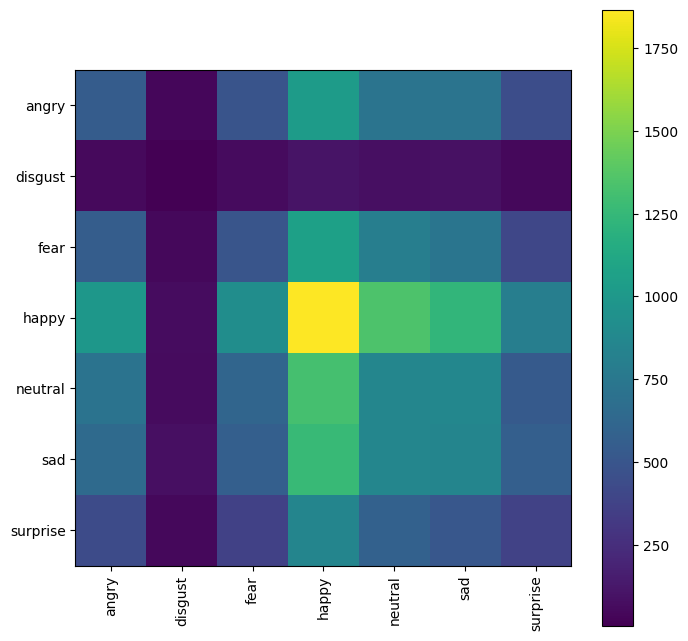

In [ ]:
y_pred = fernet.predict(training_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(training_set.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(training_set.classes, y_pred, target_names=target_names))
plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Confusion Matrix
[[141   9 111 238 180 174 105]
 [ 16   0   8  27  21  22  17]
 [155  10 112 278 184 170 115]
 [250  16 210 433 340 321 204]
 [195  11 148 300 242 212 125]
 [198  10 165 293 232 203 146]
 [126   9  81 217 164 140  94]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.15      0.14       958
     disgust       0.00      0.00      0.00       111
        fear       0.13      0.11      0.12      1024
       happy       0.24      0.24      0.24      1774
     neutral       0.18      0.20      0.19      1233
         sad       0.16      0.16      0.16      1247
    surprise       0.12      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



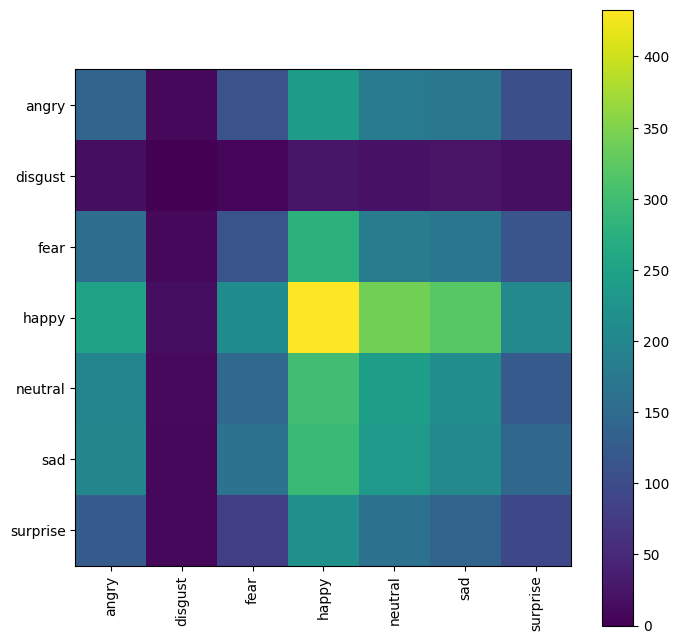

In [ ]:
y_pred = fernet.predict(test_set)
y_pred = np.argmax(y_pred, axis=1)
class_labels = test_set.class_indices
class_labels = {v:k for k,v in class_labels.items()}

#from sklearn.metrics import classification_report, confusion_matrix
cm_test = confusion_matrix(test_set.classes, y_pred)
print('Confusion Matrix')
print(cm_test)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(test_set.classes, y_pred, target_names=target_names))
plt.figure(figsize=(8,8))
plt.imshow(cm_test, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

In [ ]:
fernet.save('/content/drive/MyDrive/frentmodel.h5')